In [904]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 加载数据集
加载训练数据集，并且通过descibe()方法和isnull()方法对数据集进行简单的初步分析

In [905]:
test_data = pd.read_csv("kaggle/input/titanic/test.csv")
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [906]:
train_data = pd.read_csv("kaggle/input/titanic/train.csv")
print(train_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


为方便数据预处理，现将测试集与训练集进行合并

In [907]:
# join the two datasets
titanic = pd.concat([train_data, test_data])

In [908]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [909]:
titanic.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

## 数据预处理


Embarked属性缺失较少，所以我选择直接使用最多的类来进行缺失值的填补，对于Cabin，将缺失值标志位U (Unknown)，并且仅取第一个字母作为有效值

In [910]:
titanic['Embarked'].fillna('S', inplace = True)
titanic['Cabin'].fillna('U', inplace = True)
titanic['Cabin'] = titanic['Cabin'].map(lambda x: x[0])

Fare缺失值比较容易填补，因为Fare与Pclass高度相关，所以使用同一Pclass的票价均值来填补缺失。

In [911]:
titanic['Fare'].fillna(titanic.groupby('Pclass')['Fare'].transform('median'), inplace=True)

In [912]:
print(titanic.isnull().sum())

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
dtype: int64


接下来需要做的事情就是分析各个非数字属性，并且将其转化为有效数值属性。首先需要处理的是Name属性，通过直接观察，我们发现Name中会带有职位或者性别信息，所以通过分割进行处理。

In [913]:
titanic['Name'] = titanic['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
titanic['Name'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Name, dtype: int64

In [914]:
TitleDict = {}
TitleDict['Mr'] = 'Mr'
TitleDict['Mlle'] = 'Miss'
TitleDict['Miss'] = 'Miss'
TitleDict['Master'] = 'Master'
TitleDict['Jonkheer'] = 'Master'
TitleDict['Mme'] = 'Mrs'
TitleDict['Ms'] = 'Mrs'
TitleDict['Mrs'] = 'Mrs'
TitleDict['Don'] = 'Royalty'
TitleDict['Sir'] = 'Royalty'
TitleDict['the Countess'] = 'Royalty'
TitleDict['Dona'] = 'Royalty'
TitleDict['Lady'] = 'Royalty'
TitleDict['Capt'] = 'Officer'
TitleDict['Col'] = 'Officer'
TitleDict['Major'] = 'Officer'
TitleDict['Dr'] = 'Officer'
TitleDict['Rev'] = 'Officer'

titanic['Title'] = titanic['Name'].map(lambda x: TitleDict[x])
titanic.drop(['Name'], axis=1, inplace=True)
titanic['Title'].value_counts()

Mr         757
Miss       262
Mrs        200
Master      62
Officer     23
Royalty      5
Name: Title, dtype: int64

接下来分析SibSp与Parch这一属性，这一属性反映的是家庭成员数量，可在分析中，具体的数量可能会对最终的结果造成不良影响，所以在这里我将SibSp与Parch替换为是否独身。

In [915]:
titanic['Family'] = titanic['SibSp'] + titanic['Parch']

titanic['Alone'] = 0
titanic.loc[titanic['Family'] == 0, 'Alone'] = 1

titanic.drop(['SibSp', 'Parch', 'Family'], axis=1, inplace=True)
titanic['Alone'].value_counts()

1    790
0    519
Name: Alone, dtype: int64

In [916]:
titanic.drop(['Ticket'], axis=1, inplace=True)

In [917]:
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Alone
0,1,0.0,3,male,22.0,7.2500,U,S,Mr,0
1,2,1.0,1,female,38.0,71.2833,C,C,Mrs,0
2,3,1.0,3,female,26.0,7.9250,U,S,Miss,1
3,4,1.0,1,female,35.0,53.1000,C,S,Mrs,0
4,5,0.0,3,male,35.0,8.0500,U,S,Mr,1


In [918]:
titanic['Cabin'].value_counts()
titanic['Embarked'].value_counts()

S    916
C    270
Q    123
Name: Embarked, dtype: int64

In [919]:
# map categorical features to numerical values
titanic['Cabin'] = titanic['Cabin'].map({'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4, 'F' : 5, 'G' : 6, 'T' : 7, 'U' : 8})
titanic['Sex'] = titanic['Sex'].map({'male' : 0, 'female' : 1})
titanic['Embarked'] = titanic['Embarked'].map({'S' : 0, 'C' : 1, 'Q' : 2})
titanic['Title'] = titanic['Title'].map({'Mr' : 0, 'Miss' : 1, 'Mrs' : 2, 'Master' : 3, 'Officer' : 4, 'Royalty' : 5})

In [920]:
print(titanic.info())
print(titanic.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   int64  
 4   Age          1046 non-null   float64
 5   Fare         1309 non-null   float64
 6   Cabin        1309 non-null   int64  
 7   Embarked     1309 non-null   int64  
 8   Title        1309 non-null   int64  
 9   Alone        1309 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 112.5 KB
None
   PassengerId  Survived  Pclass  Sex   Age     Fare  Cabin  Embarked  Title  \
0            1       0.0       3    0  22.0   7.2500      8         0      0   
1            2       1.0       1    1  38.0  71.2833      2         1      2   
2            3       1.0       3    1  26.0   7.9250      8         0      1   
3            

至此，除Age之外的属性都已处理完毕，接下来需要对Age进行处理，其中我们需要分析Age的分布情况，并且将其转化为数值属性。

(10.5, -0.5)

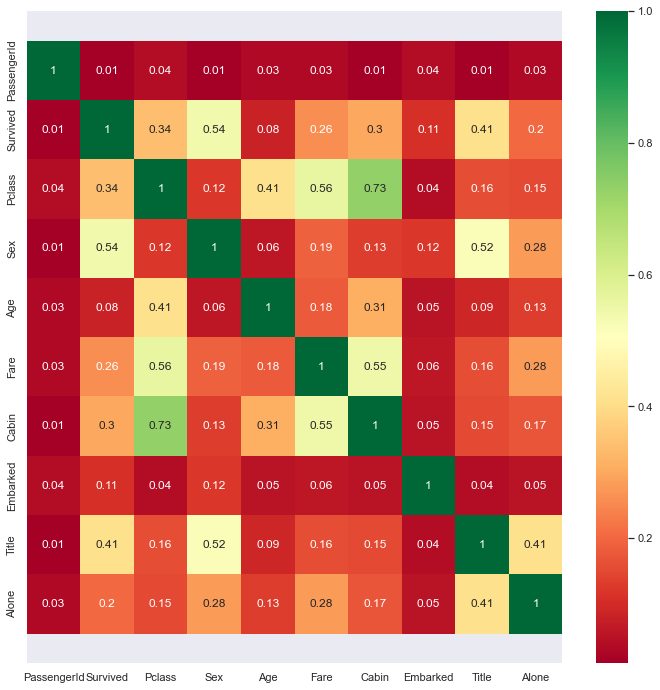

In [921]:
import seaborn as sns
correlation_matrix = np.absolute(titanic.corr().round(2))
sns.set(rc={'figure.figsize':(12, 12)})
ax = sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [922]:
variables = ['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Title', 'Alone']
trainAge = titanic[variables]

最后我们再来填补缺失的 Age属性，使用随机森林进行填补。在此之前需要大致的决定哪些属性与Age最密切，使用heatmap来直观的查看相关系数。

In [923]:
#拆分实验集和预测集
AgeKnown = trainAge[trainAge['Age'].notnull()]
AgeUnKnown = trainAge[trainAge['Age'].isnull()]

#生成实验数据的特征和标签
AgeKnown_X = AgeKnown.drop(['Age'],axis=1)
AgeKnown_y = AgeKnown['Age']
#生成预测数据的特征
AgeUnKnown_X = AgeUnKnown.drop(['Age'],axis=1)

#利用随机森林构建模型
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(random_state=None,n_estimators=500,n_jobs=-1)
rfr.fit(AgeKnown_X, AgeKnown_y)

RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [924]:
#模型得分
print(rfr.score(AgeKnown_X, AgeKnown_y))

#预测年龄
AgeUnKnown_y = rfr.predict(AgeUnKnown_X)
#填充预测数据
titanic.loc[titanic['Age'].isnull(), ['Age']] = AgeUnKnown_y
titanic.info()  #此时已无缺失值

0.7400822492489685
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   int64  
 4   Age          1309 non-null   float64
 5   Fare         1309 non-null   float64
 6   Cabin        1309 non-null   int64  
 7   Embarked     1309 non-null   int64  
 8   Title        1309 non-null   int64  
 9   Alone        1309 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 112.5 KB


In [925]:
titanic.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Sex              0
Age              0
Fare             0
Cabin            0
Embarked         0
Title            0
Alone            0
dtype: int64

由于决策树算法限制，我们还需要把所有数据归组。

In [926]:
titanic.loc[titanic['Fare'] <= 7.91, 'Fare'] = 0
titanic.loc[(titanic['Fare'] > 7.91) & (titanic['Fare'] <= 14.454), 'Fare'] = 1
titanic.loc[(titanic['Fare'] > 14.454) & (titanic['Fare'] <= 31), 'Fare'] = 2
titanic.loc[titanic['Fare'] > 31, 'Fare'] = 3

titanic.loc[titanic['Age'] <= 16, 'Age'] = 0
titanic.loc[(titanic['Age'] > 16) & (titanic['Age'] <= 32), 'Age'] = 1
titanic.loc[(titanic['Age'] > 32) & (titanic['Age'] <= 48), 'Age'] = 2
titanic.loc[(titanic['Age'] > 48) & (titanic['Age'] <= 64), 'Age'] = 3
titanic.loc[titanic['Age'] > 64, 'Age'] = 4

titanic['Age'] = titanic['Age'].astype(int)
titanic['Fare'] = titanic['Fare'].astype(int)

In [927]:
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Alone
0,1,0.0,3,0,1,0,8,0,0,0
1,2,1.0,1,1,2,3,2,1,2,0
2,3,1.0,3,1,1,1,8,0,1,1
3,4,1.0,1,1,2,3,2,0,2,0
4,5,0.0,3,0,2,1,8,0,0,1


In [928]:
# one-hot编码
# titanic = pd.get_dummies(titanic)
# Ageonehot = pd.get_dummies(titanic['Age'], prefix = 'Age')
# Fareonehot = pd.get_dummies(titanic['Fare'], prefix = 'Fare')

# titanic = pd.concat([titanic, Ageonehot, Fareonehot], axis=1)
# titanic.drop(['Age', 'Fare'], axis=1, inplace=True)
# titanic.head()

In [929]:
traindata = titanic[titanic['Survived'].notnull()]
testdata = titanic[titanic['Survived'].isnull()]

In [930]:
# 将Survived类转为int类型
traindata['Survived'] = traindata['Survived'].astype(int)
traindata

C:\Users\chris\AppData\Local\Temp\ipykernel_12072\948573567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindata['Survived'] = traindata['Survived'].astype(int)


,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Alone
0,1,0,3,0,1,0,8,0,0,0
1,2,1,1,1,2,3,2,1,2,0
2,3,1,3,1,1,1,8,0,1,1
3,4,1,1,1,2,3,2,0,2,0
4,5,0,3,0,2,1,8,0,0,1
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,1,1,8,0,4,1
887,888,1,1,1,1,2,1,0,1,1
888,889,0,3,1,0,2,8,0,1,0
889,890,1,1,0,1,2,2,1,0,1


In [931]:
testdata

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Alone
0,892,NaN,3,0,2,0,8,2,0,1
1,893,NaN,3,1,2,0,8,0,2,0
2,894,NaN,2,0,3,1,8,2,0,1
3,895,NaN,3,0,1,1,8,0,0,1
4,896,NaN,3,1,1,1,8,0,2,0
...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,0,1,1,8,0,0,1
414,1306,NaN,1,1,2,3,2,1,5,1
415,1307,NaN,3,0,2,0,8,0,0,1
416,1308,NaN,3,0,1,1,8,0,0,1


使用随机森林进行预测

In [932]:
from sklearn.ensemble import RandomForestClassifier

y = traindata['Survived']

X = traindata.drop(['Survived', 'PassengerId'], axis=1)
X_test = testdata.drop(['Survived', 'PassengerId'], axis=1)

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': testdata.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


使用XGBoost进行预测

In [933]:
# from xgboost import XGBClassifier
# y = traindata['Survived']
# X = traindata.drop(['Survived', 'PassengerId'], axis=1)
# X_test = testdata.drop(['Survived', 'PassengerId'], axis=1)

# model = XGBClassifier(
#     learning_rate=0.02,
#     n_estimators=10, 
#     max_depth=5, 
#     min_child_weight=1,
#     scale_pos_weight=1,
#     random_state=1
#     )

# model.fit(X, y)
# predictions = model.predict(X_test)

# output = pd.DataFrame({'PassengerId': testdata.PassengerId, 'Survived': predictions})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

评估正确率

In [934]:
# #导入机器学习算法库
# from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold
# from sklearn.ensemble import VotingClassifier #模型组合

# #设置kfold
# kfold=StratifiedKFold(n_splits=10) #利用分层采样方法生成交叉验证数据集

In [935]:
# #RandomForestCla模型
# RFC = RandomForestClassifier()
# rf_param_grid={'max_depth':[None],
#               'max_features':[1,3,10],
#               'min_samples_split':[2,3,10],
#               'min_samples_leaf':[1,3,10],
#               'bootstrap':[False],
#               'n_estimators':[100,300],
#               'criterion':['gini']}
# modelgsRFC=GridSearchCV(RFC,param_grid=rf_param_grid,cv=kfold,
#                        scoring='accuracy',n_jobs=-1,verbose=1)
# modelgsRFC.fit(X, y)
# RFC_best=modelgsRFC.best_estimator_

In [936]:
def accuracy(predy, y):
    return sum(predy == y) / len(y)

gender = pd.read_csv('gender_submission.csv')
gendery = gender['Survived']

predict = pd.read_csv('submission.csv')
predy = predict['Survived']

# compare gendery and predy
score = accuracy(predy, gendery)
score

0.9090909090909091